# Intro
In this example from **Chapter 3** of Geron's book we will look at the MNIST dataset, which is a set of 70,000 small images of handwritten digits. Each image is labeled with the digit it represents.

## Loading the data

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)

`sklearn.datasets` contains mostly 3 types of functions:

- `fetch_*` for downloading real-life datasets

- `load_*` for loading small you datasets bundled with Scikit-Learn

- `make_*` for generating fake datasets used in testing

Generated datasets are usually returned as an (X, y) tuple, containint features and targets - both as NumPy arrays.

In [3]:
X, y = mnist.data, mnist.target

In [4]:
X.shape # 70,000 images of 28x28 = 784 pixels

(70000, 784)

In [5]:
print(y) # each number represents a class
y.shape

['5' '0' '4' ... '4' '5' '6']


(70000,)

^ each image has 784 features - each pixel is a feature. Each feature is a value from 0 (white) to 255 (black).

Let's take a look at one of the digits:

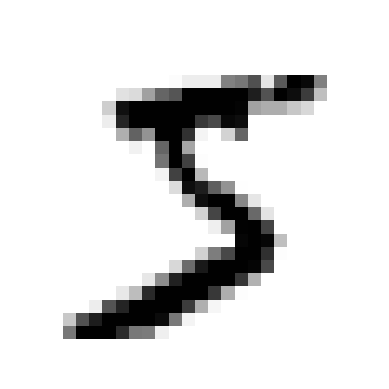

In [6]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28) # reshape the vector into a 28x28 matrix
    plt.imshow(image, cmap="binary") # cmap = binary => black & white colormap
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [7]:
y[0] # the label for the above image

'5'

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] # fetch_openml already shuffled the data

## Binary Classifier

For now let's train a simple model - a _binary classifier_. It will be able to distinguish between two classes - 5 and non-5.

In [9]:
y_train_5 = (y_train == '5') # create new features and labels vectors
y_test_5 = (y_test == '5')

A good classifier is the [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (or just SGD). This classifier handles very big datasets quite efficiently:

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit]) # some_digit is a 5 - the classifier guesses right

array([ True])

## Evaluation
Evaluating classifiers is much trickier than evaluation a regressor. There are many performance measures available. 

### Cross-Validation

Similar to what we did in the housing example, we can use cross-validation here too. We will use k-fold cross-validation - this means we'll split the training set into k folds, then train the model k times, using a different fold for evaluation each time.

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") # cv - cross validation

array([0.95035, 0.96035, 0.9604 ])

^ Over 95% accuracy! This looks good, but is a bit suspicious.

 Let's look at a dummy classifier that just classifies every single image in the most frequent class, which in our case is the "non-5" class:

In [13]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

print(any(dummy_clf.predict(X_train)))

cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

False


array([0.90965, 0.90965, 0.90965])

^ The accuracy is indeed above 90%. This is simply because only about 10% of the images are actually 5s, so if the model always guesses that an image is _not_ a 5, then it will be right 90% of the time.

This demonstrates why accuracy is generally not the best performance measure for classifiers - especially when we are dealing with _skewed datasets_ (i.e. when some classes are much more prevalent than others).

A much better way to evaluate a classifier is by using a _confusion matrix_.

### Confusion Matrices

The general idea of a CM is to count the number of times instances of one class are classified as another class.

In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cm = confusion_matrix(y_train_5, y_train_pred)
print(cm)

[[53892   687]
 [ 1891  3530]]


^ each row in the confusion matrix is an _actual_ class, while each column is a _predicted_ class. 

The first row is the non-5 class: 53,892 of the images were correctly classified as non-5s. The remaining 687 were wrongly classified as 5s - called _false positives_.

The second row considers the images of 5s. 1,891 were wrongly classified as non-5s (_false negatives_), while the remaining 3,530 were correctly classified as 5s. 

A perfect classifier would only have true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal.


### Precision and Recall

Sometimes we may prefer a more concise metric. A good one to look at is the accuracy of positive predictions, called the _precision_ of the classifier:

$$
precision = \frac{TP}{TP+FP}
$$

- $TP$ - number of true positives
- $FP$ - number of false positives

Precision is typically used along with another metric named _recall_, _sensitivity_ or _true positive rate (TPR)_.

$$
recall = \frac{TP}{TP + FN}
$$

- $FN$ - number of false negatives


Scikit-Learn provides several functions for computing classifier metrics, including precision and recall:

In [15]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


^ we can now see that:

- when the classifier claims an image contains a 5, it is correct only 83.7% of the time

- the classifier detects only 65.1% of the 5s

It is convenient to combine precision and recall into a single metric called the "$F_1$ _score_". It is the _harmonic mean_ of precision and recall:

$$
F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 * \frac{precision * recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}
$$

In [16]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

### More about the $F_1$ score

The $F_1$ score favors classifiers that have similar precision and recall. However, in some contexts you may want greater precision while in others you only care about recall.

For example, if you want a model that detects videos that are safe for kids, you would rather have a classifier that rejects many good videos (low recall) but is guaranteed to keep only the safe ones (high precision). A classifier that has a high recall but lets a few bad videos show up would not be acceptable in this case.

On the other hand, if you want to have a classifier that detects shoplifters, it is probably fine if it has a low precision as long as the recall is very high - the security guards may get a few false alerts but almost all shoplifters will get caught in this case.

Sadly, increasing precision reduces recall and vice versa. This is called the _precision/recall trade-off_.

## The Precision/Recall Trade-Off

To understand this trade-off, let's lookk at how the `SGDClassifier` makes its classification decisions:

For each instance, it computes a score based on a _decision function_. If that score is greater than a treshold, it assignes the instance to the positive class - otherwise to the negative class.

Scikit-Learn doest not let you set this threshold directly, but instead gives you access to the decision scores that it uses for it predictions:

In [17]:
y_scores = sgd_clf.decision_function([some_digit]) # .decision_function returns a score for each instance
y_scores

array([2164.22030239])

In [18]:
threshold = 0
y_some_digit_pred = (y_scores > threshold) # check if scores are greater than 0
y_some_digit_pred

array([ True])

^ The `SGDClassifier` uses a threshold equal to 0, so the code returns the same result as the `.predict()` method. You can play with the threshold value and see what happens.

So how do we decide what threshold to use? 

First, we can use the `cross_val_predict()` function to get the scores of all instances in the training set:

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function") # specify that you want decision scores insteead of predictions

In [20]:
from sklearn.metrics import precision_recall_curve

# compute precisionn and recall for all possible thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

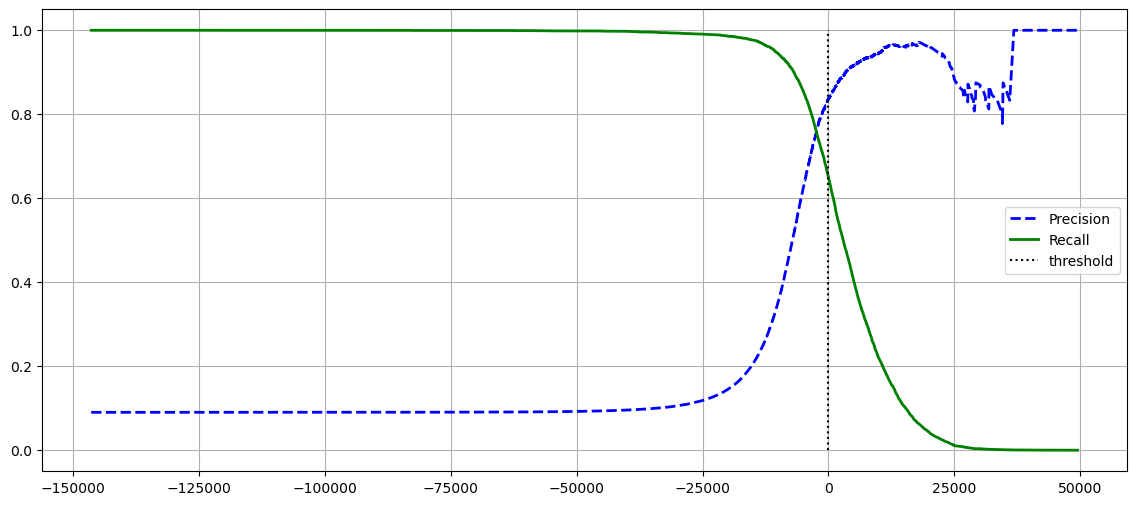

In [21]:
plt.figure(figsize=(14, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.grid(True)
plt.legend()
plt.show()

^ when the threshold is 0, precision is near 90% while recall is around 50%. 

Another way to select a good precision/recall trade-off is to plot precision directly against recall:

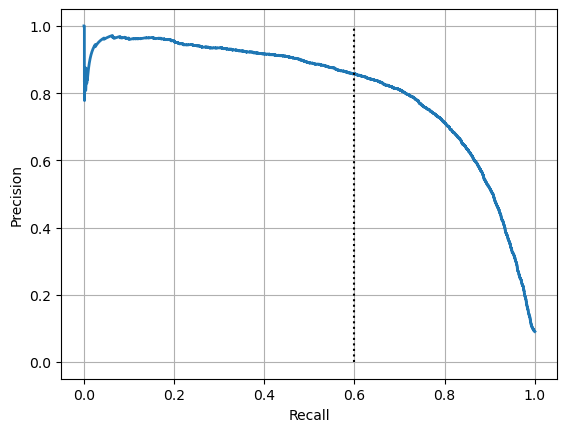

In [22]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.vlines(0.6, 0, 1.0, "k", "dotted")
plt.grid(True)

^ Precision starts to fall sharply after 80% recall. It is a good idea to select a trade-off just before the drop - ar around 60% recall, for example.

Suppose we want to aim for 90% precision. We can now search for the lowest possible threshold that still gives us at least 90% precision:

In [23]:
idx_for_90_precision = (precisions >= 0.9).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]

threshold_for_90_precision

3370.0194991439557

In [24]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [25]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [26]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

^ we now have a 90% precision classifier - BUT!

The recall is only 48% - which is actually not great at all.

### The ROC Curve

The _[Receiver Operating Characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)_ (ROC) curve is another tool used with binary classifiers. 

It is similar to the precision/recall curve but instead of plotting precision vs recall, the ROC curve plots the _true positive rate_ (another name for recall) against the _false positive rate_ (FPR).

The FPR (also called _fall-out_) is the ratio of negative instances that are wrongly classified as positive. It is equal to $1 - TNR$, where TNR is the _true negative rate_ - also called _specificity_.

In other words, the ROC curve plots _sensitivity_ versus 1 - _specificity_.

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores) # compute TPR and FPR

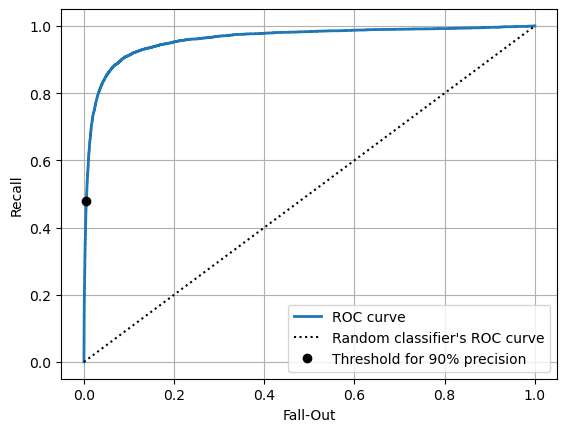

In [28]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.grid(True)
plt.legend()
plt.xlabel("Fall-Out")
plt.ylabel("Recall")
plt.show()

Once again there is a trade-off: the higher the TPR, the higher the FPR. 

The dotted line is the ROC curve of a purely random classifier - a good classifier stays as far away from that line as possible (towards the top-left corner).

One way to compare classifiers is to measure their _Area under the curve_ (AUC). A perfect classifier will have a ROC AUC equal to 1. A purely random one - to 0.5.

We can estimate the ROC AUC with Scikit-Learn:

In [29]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Now let's create a random forest classifier whose PR curve and $F_1$ score we can compare to those of the SGD classifier:

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [31]:
y_probas_forest[:2] # class probabilities for the first two images in the training set

array([[0.11, 0.89],
       [0.99, 0.01]])

^ The model predicts the first image is positive with 89% probability, and that the second image is negative with 99% probability.

*Keep in mind that these are _estimated_ and not actual probabilities.

In [32]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

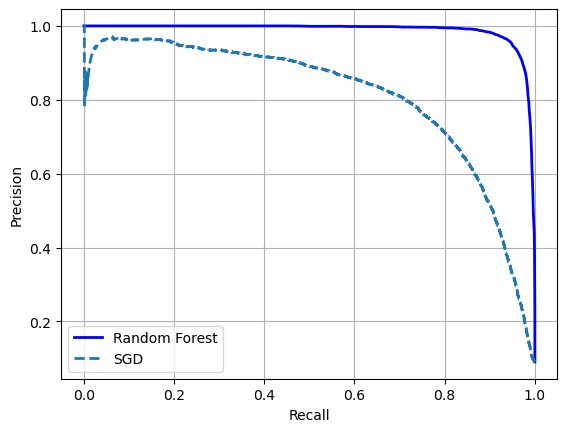

In [33]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.grid(True)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

^ the random forest classifier is superior to the SGD classifier because its PR curve is much closer to the top-right corner and has a greater AUC.

In [34]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5

print(f1_score(y_train_5, y_train_pred_forest))

print(roc_auc_score(y_train_5, y_scores_forest))

0.9274509803921569
0.9983436731328145


## Multiclass Classification

Multiclass classfieirs are also called _multinomial classifiers_ and they can distinguish between more than 2 classes.

`SGDClassifier` and `SVC` from Skicit-Learn are strictly binary classifiers. Others, like `LogisticRegression`, `RandomForestClassifier` and `GaussianNB` can handle  multiple classes natively.

There are several ways to create a system that can classify the digit images into 10 classes (from 0 to 9):

1. We can train 10 binary classifiers (one for each digit -  a 0-detector, 1-detector, 2-detector etc.). Then we can get the decision score from each classifier for a certain image and select the class whose classifier outputs the highest score. This is called _one-versus-the-rest_ (OvR) or _one-versus-all_ (OvA) method.

2. We can also train a binary classifier for every pair of digits. This is called the _one-versus-one_ (OvO) strategy. If there are $N$ classes, we will need to train $N*\frac{N-1}{2}$ classifiers. For the MNIST dataset, this means training 45 binary classifiers (quite a lot!).

Some algorithms scale poorly with the size of the training set. For these cases OvO is better because it is faster to train many classifiers on smaller training sets that a few classifier on very large sets.

Scikit-Learn automatically runs OvR or OvO when we try to use a binary classification algorithm for a multiclass classification task.

In [35]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) # we'll take the first 2000 images for faster training

SVC(random_state=42)

In [36]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [37]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

^ Scikit-Learn used the OvO strategy and trained 45 binary classifiers. 

There are 10 scores per instance - one for each class. 

It selected the class that "won the most duels". Each class got a score equal to the number of won duels +- 0.33 for breaking ties.

If you want to force Scikit-Learn to use OvO or OvR you can use `OneVsOneClassifier` or `OneVsRestClassifier` classes:

In [38]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [39]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')